# Deep Architectures for Sampling Molecules

You will use tools from Deeptime (https://deeptime-ml.github.io/) to implement a VAMPNET. You will then train a decoder to generate plausible conformational changes of molecules.

The paper associated with the Deeptime package is: 
Hoffmann, M., Scherer, M.K., Hempel, T., Mardt, A., de Silva, B., Husic, B.E., Klus, S., Wu, H., Kutz, N., Brunton, S.L., & Noé, F. (2021). Deeptime: a Python library for machine learning dynamical models from time series data. Machine Learning: Science and Technology, 3.


## Tutorial 1
### Let us start by getting familiar with Deeptime

To install Deeptime: `pip install deeptime` (see https://deeptime-ml.github.io/latest/index.html).

Let us now generate a simple 2-D time series and extract a 1D compressed signal to learn more on how deeptime's VAMPNET works.

Reference: https://deeptime-ml.github.io/latest/notebooks/vampnets.html


c:\ProgramData\anaconda3\envs\deeplife_env\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Text(0.5, 1.0, 'Heatmap of observations')

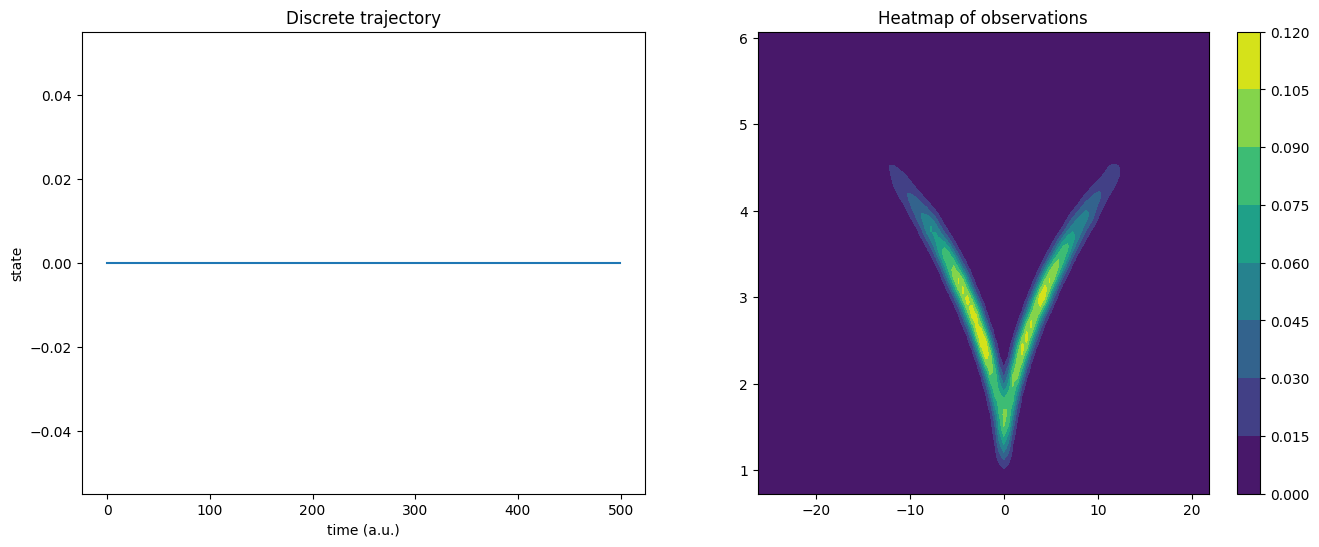

In [1]:
import numpy as np

import torch
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(12)

from deeptime.data import sqrt_model

# The folowing generates samples of states and observations of a HMM (https://deeptime-ml.github.io/latest/api/generated/deeptime.data.sqrt_model.html)
#The hidden variables takes two values 0 or 1 and oberved variable is a vector in 2D. 

dtraj, traj = sqrt_model(n_samples=10000)

#The folowing is a plot of the time series
import scipy.stats as stats
import matplotlib.pyplot as plt

X, Y = np.meshgrid(
    np.linspace(np.min(traj[:, 0]), np.max(traj[:, 0]), 100),
    np.linspace(np.min(traj[:, 1]), np.max(traj[:, 1]), 100),
)
kde_input = np.dstack((X, Y)).reshape(-1, 2)

kernel = stats.gaussian_kde(traj.T, bw_method=.1)
Z = kernel(kde_input.T).reshape(X.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(dtraj[:500])
ax1.set_title('Discrete trajectory')
ax1.set_xlabel('time (a.u.)')
ax1.set_ylabel('state')

cm = ax2.contourf(X, Y, Z)
plt.colorbar(cm, ax=ax2)
ax2.set_title('Heatmap of observations')



In [2]:
#In order to work with the VAMPNet / PyTorch API it can be convenient to first convert the trajectory into a time-lagged dataset.

from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, traj.astype(np.float32))


In [3]:
n_val = int(len(dataset)*.3)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])


#The neural network 
from deeptime.util.torch import MLP
lobe = MLP(units=[traj.shape[1], 15, 10, 10, 5, 1], nonlinearity=nn.ReLU)
print(lobe)

lobe = lobe.to(device=device)


MLP(
  (_sequential): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): ReLU()
    (8): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [4]:
from deeptime.decomposition.deep import VAMPNet

vampnet = VAMPNet(lobe=lobe, learning_rate=1e-4, device=device)

# Dataset train valid

from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=512, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)


#Train
from tqdm.notebook import tqdm
model = vampnet.fit(loader_train, n_epochs=160,
                    validation_loader=loader_val, progress=tqdm).fetch_model()


VAMPNet epoch:   0%|          | 0/160 [00:00<?, ?it/s]

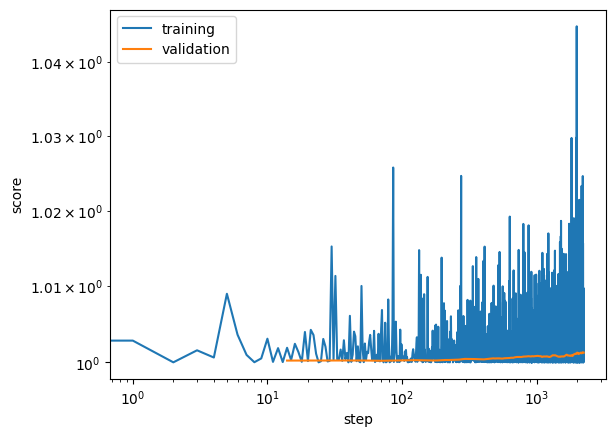

In [5]:
#Plot loss
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend()

## Tutorial 2
### Let us see how to learn an MSM
Taken from https://deeptime-ml.github.io/latest/notebooks/mlmsm.html

For a discrete Markov chain $\pi(y \mid x)$, with a finite state space $\Omega$ and finite time steps, the likelihood of a sample trajectory $(x_t, t \leq T)$ is given by,
$$L(\pi)= \prod_{x,y \in \Omega} \pi(y \mid x)^{C_{y,x}}$$

where $C_{y,x}$ is the number of times the transition $x \to y$ happened. One can derive the maximum likelihood estimate analytically. This is what the following function MaximumLikelihoodMSM will be used for.



In [6]:
import deeptime.markov as markov

estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)



In [7]:
# Generting a Markov chain with three states
import numpy as np

p11 = 0.97
p22 = 0.97
p33 = 0.97
P = np.array([[p11, 1 - p11, 0], [.5*(1 - p22), p22, 0.5*(1-p22)], [0, 1-p33, p33]])
true_msm = markov.msm.MarkovStateModel(P)

# Generating samples of that Markov chain
trajectory = true_msm.simulate(50000)

#Counting the trnaistions
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding"
)
counts = counts_estimator.fit(trajectory).fetch_model()

# The MLE MSM
msm = estimator.fit(counts).fetch_model()

#Printing the learned MSM
print("Estimated transition matrix:", msm.transition_matrix)
print("Estimated stationary distribution:", msm.stationary_distribution)

Estimated transition matrix: [[1.]]
Estimated stationary distribution: [1.]


## Exercice 
### VAMPNerts for Alanine Dipeptide

In [8]:
#pip install mdshare
import mdshare

#The time series of Alanine Dipeptide 
ala_coords_file = mdshare.fetch("alanine-dipeptide-3x250ns-heavy-atom-positions.npz", working_directory="data")

with np.load(ala_coords_file) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]


### Question 1

Learn a VAMPNET on the time series of Alanine Dipeptide. The variable for this VAMPNET will be called "model."

Hint: See [this example](https://deeptime-ml.github.io/latest/notebooks/examples/ala2-example.html).


In [9]:
# define the dataset 
from deeptime.util.data import TrajectoriesDataset
dataset = TrajectoriesDataset.from_numpy(1, data)

# split into train and validation datasets
n_val = int(len(dataset)*.1)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

# define lobe 
lobe = nn.Sequential(
    nn.BatchNorm1d(data[0].shape[1]),
    nn.Linear(data[0].shape[1], 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 6),
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
)

lobe = lobe.to(device=device)

model = VAMPNet(lobe=lobe, learning_rate=5e-3, device=device)

loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

model = model.fit(loader_train, n_epochs=30,
                    validation_loader=loader_val, progress=tqdm)


VAMPNet epoch:   0%|          | 0/30 [00:00<?, ?it/s]

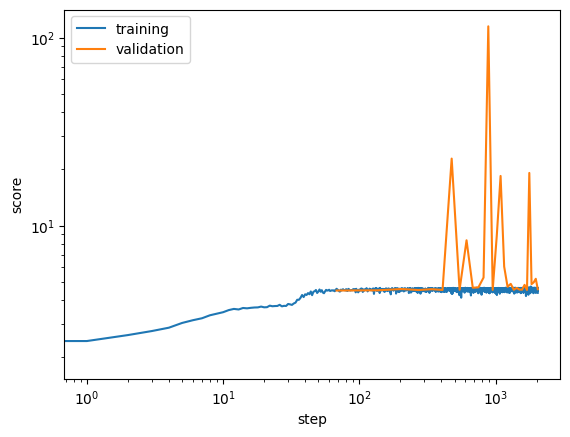

In [10]:
plt.loglog(*model.train_scores.T, label='training')
plt.loglog(*model.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend()

### Question 2

The VAMPNET compresses the time series, it plays the role of an encoder; the output of the VAMPNET plays the role of a 'latent space.'

2.1) Cluster the compressed time series dataset.

Hint: The compressed dataset is the collection of compressed configurations $model(x_t)$


In [11]:
state_probabilities = model.transform(data[0])

clustered = state_probabilities.argmax(axis=1)
print(clustered.shape)
print(np.bincount(clustered))

(250000,)
[15894 63180   378 94509  7687 68352]


### Question 3

3.1) Learn an MSM from the clustering on the compressed dataset.

3.2) Generate samples from this learned discrete Markov chain.

Hint: Refer to tutorial 2.


In [12]:
# The MLE MSM
msm = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

#Counting the trnaistions
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding", n_states=6
)
counts = counts_estimator.fit(clustered).fetch_model()

# fit msm
msm = msm.fit(counts).fetch_model()

#Printing the learned MSM
print("Estimated transition matrix:", msm.transition_matrix)
print("Estimated stationary distribution:", msm.stationary_distribution)

Estimated transition matrix: [[4.65332825e-01 1.73973103e-02 0.00000000e+00 1.88759325e-03
  0.00000000e+00 5.15382271e-01]
 [4.37618154e-03 7.34029760e-01 0.00000000e+00 2.54756364e-01
  0.00000000e+00 6.83769467e-03]
 [0.00000000e+00 0.00000000e+00 9.52380953e-01 0.00000000e+00
  4.76190475e-02 0.00000000e+00]
 [3.17415196e-04 1.70306459e-01 0.00000000e+00 8.22588329e-01
  6.34860369e-05 6.72431078e-03]
 [0.00000000e+00 0.00000000e+00 2.34161572e-03 7.80538333e-04
  9.96877846e-01 0.00000000e+00]
 [1.19830200e-01 6.32023597e-03 0.00000000e+00 9.29748079e-03
  0.00000000e+00 8.64552083e-01]]
Estimated stationary distribution: [0.06357025 0.25272064 0.00151201 0.37803728 0.03074812 0.27341171]


In [ ]:
# Generate samples of the Markov chain
generator = markov.msm.MarkovStateModel(transition_matrix=msm.transition_matrix, # stationary_distribution=msm.stationary_distribution, 
                                        # count_model = counts, lagtime=1
                                        )

# Generating samples of that Markov chain
generated_samples = generator.simulate(50000)
print(generated_samples.shape)
print(np.bincount(generated_samples))

def simulate_msm(P, initial_state, n_steps):
    state = initial_state
    traj = []
    for _ in range(n_steps):
        traj.append(state)
        state = np.random.choice(len(P), p=P[state])
    return np.array(traj)

simul = simulate_msm(msm.transition_matrix, 0, 50000)
print(simul.shape)
print(np.bincount(simul))

# somehow MarkovStateModel does not work correctly .... 


(50000,)
[    0 50000]
(50000,)
[ 3334 13076     0 19463     0 14127]


### Question 4
4.1) Freeze the weights of the encoder and learn a decoder to generate configurations of Alanine Dipeptide from the clusters.

4.2) Generate samples of the time evolution of Alanine Dipeptide from this learned discrete Markov chain.

Hint: Freeze the weights of the VAMPNET, define a neural network that will serve as the decoder. The full network is Decoder + Encoder with frozen weights. Train the autoencoder with the Mean Square Error and use gradient descent for training.


In [17]:
# Freeze the weights of the VAMPNET, define a neural network that will serve as the decoder. The full network is Decoder + Encoder with frozen weights. 
# Train the autoencoder with the Mean Square Error and use gradient descent for training.


class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder          # VAMPNET encoder
        # freeze the weight 
        for param in self.encoder.parameters():
            param.requires_grad = False                  

        self.decoder = nn.Sequential(               #decoder 
            nn.Linear(6, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, data[0].shape[1])  
        )

    def forward(self, x):
        with torch.no_grad():
            encoded = self.encoder(x)
        return self.decoder(encoded)
    
    def train(self, mode: bool = True):
        super().train(mode)
        self.encoder.eval()
        return self
    
    def fit(self, train_loader, epochs, optimizer, loss_fn, device):
        self.train()  # set model to training mode
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                x_batch = batch[0].to(device)
                x_recon = self(x_batch)
                loss = loss_fn(x_recon, x_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
auto = Autoencoder(model.lobe)

auto.fit(loader_train, epochs=30, 
         optimizer=torch.optim.SGD(auto.decoder.parameters(), lr=1e-3), 
         loss_fn=nn.MSELoss(), device=device
         )




Epoch 1, Loss: 129.8959
Epoch 2, Loss: 127.3054
Epoch 3, Loss: 124.7573
Epoch 4, Loss: 122.2385
Epoch 5, Loss: 119.7386
Epoch 6, Loss: 117.2455
Epoch 7, Loss: 114.7414
Epoch 8, Loss: 112.2232
Epoch 9, Loss: 109.6869
Epoch 10, Loss: 107.1035
Epoch 11, Loss: 104.4603
Epoch 12, Loss: 101.7412
Epoch 13, Loss: 98.9447
Epoch 14, Loss: 96.0648
Epoch 15, Loss: 93.0939
Epoch 16, Loss: 90.0239
Epoch 17, Loss: 86.8493
Epoch 18, Loss: 83.5619
Epoch 19, Loss: 80.1517
Epoch 20, Loss: 76.6188
Epoch 21, Loss: 72.9663
Epoch 22, Loss: 69.1998
Epoch 23, Loss: 65.3266
Epoch 24, Loss: 61.3574
Epoch 25, Loss: 57.3093
Epoch 26, Loss: 53.2020
Epoch 27, Loss: 49.0631
Epoch 28, Loss: 44.9150
Epoch 29, Loss: 40.7912
Epoch 30, Loss: 36.7385


In [21]:
#   Generate samples of the time evolution of Alanine Dipeptide from this learned discrete Markov chain.
decoded_samples = auto.decoder(torch.eye(6)[generated_samples])
print(decoded_samples[:2])

# generate sample for manually generated Markov chain
manually_decoded = auto.decoder(torch.eye(6)[simul])
print(manually_decoded[:2])

tensor([[ 0.0599,  1.2913,  0.0483,  0.1520,  1.2188,  0.1337,  0.0356,  1.1855,
          0.0217, -0.0597,  1.0545,  0.2492,  0.1057,  0.9599,  0.0384,  0.0627,
          1.0654, -0.1622,  0.0326,  1.2567,  0.2593,  0.0185,  0.9652,  0.1074,
          0.0583,  1.0714, -0.1054, -0.0058,  0.7564, -0.0356],
        [ 0.0599,  1.2913,  0.0483,  0.1520,  1.2188,  0.1337,  0.0356,  1.1855,
          0.0217, -0.0597,  1.0545,  0.2492,  0.1057,  0.9599,  0.0384,  0.0627,
          1.0654, -0.1622,  0.0326,  1.2567,  0.2593,  0.0185,  0.9652,  0.1074,
          0.0583,  1.0714, -0.1054, -0.0058,  0.7564, -0.0356]],
       grad_fn=<SliceBackward0>)
tensor([[ 0.1278,  1.5748,  0.1217,  0.2055,  1.5449,  0.1831,  0.0127,  1.5083,
          0.0141, -0.0160,  1.2431,  0.2796,  0.1433,  1.1469,  0.0866,  0.1229,
          1.2628, -0.1889,  0.0558,  1.6167,  0.3226,  0.0551,  1.1474,  0.2291,
          0.1138,  1.3250, -0.0976,  0.0150,  0.8828, -0.0564],
        [ 0.1249,  1.2143,  0.0246,  0.1497, 